wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\48242450\_netrc
wandb: Network error (SSLError), entering retry loop.


Index(['Gender', 'Age', 'Schooling', 'Breastfeeding', 'Varicella',
       'Initial_Symptom', 'Mono_or_Polysymptomatic', 'Oligoclonal_Bands',
       'LLSSEP', 'ULSSEP', 'VEP', 'BAEP', 'Periventricular_MRI',
       'Cortical_MRI', 'Infratentorial_MRI', 'Spinal_Cord_MRI', 'Initial_EDSS',
       'Final_EDSS', 'group'],
      dtype='object')
Gender                       0
Age                          0
Schooling                    1
Breastfeeding                0
Varicella                    0
Initial_Symptom              1
Mono_or_Polysymptomatic      0
Oligoclonal_Bands            0
LLSSEP                       0
ULSSEP                       0
VEP                          0
BAEP                         0
Periventricular_MRI          0
Cortical_MRI                 0
Infratentorial_MRI           0
Spinal_Cord_MRI              0
Initial_EDSS               148
Final_EDSS                 148
group                        0
dtype: int64
Fitting 5 folds for each of 72 candidates, totalling 360 fi

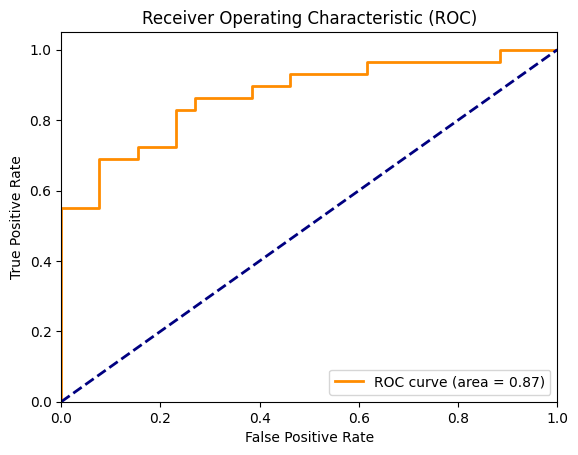

Modelo guardado exitosamente.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import wandb
import pickle  # Necesario para guardar el modelo
import os

# Crear la carpeta 'models' si no existe
os.makedirs("models", exist_ok=True)

# Configuración para wandb
os.environ["WANDB_NOTEBOOK_NAME"] = "SVM.ipynb"
wandb.login(key="79ae8864c00938f75bc754c55a37bda8fee5664c")
wandb.login()

# Cargar los datos desde el CSV, ignorando la columna de índice
df = pd.read_csv('./data.csv', index_col=0)

# Verificar los nombres de las columnas
print(df.columns)

# Revisar si hay valores faltantes en el dataframe
print(df.isna().sum())

# Imputar valores faltantes
imputer = SimpleImputer(strategy='mean')
X = df.drop(['group', 'Initial_EDSS', 'Final_EDSS'], axis=1)
y = df['group']

# Imputar valores faltantes en X
X_imputed = imputer.fit_transform(X)

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Codificar las etiquetas
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Definir el modelo SVM y los parámetros para la búsqueda en GridSearchCV
svm_model = SVC(probability=True)

# Parámetros para explorar
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],  # Regularización
    'gamma': ['scale', 'auto'],  # Parámetro del kernel RBF y polinómico
    'degree': [3, 4, 5]  # Solo se aplica al kernel polinomial
}

# Implementar GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_model = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")

# Hacer predicciones con el mejor modelo
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Evaluar el modelo
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Calcular ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=best_model.classes_[1])
roc_auc = roc_auc_score(y_test, y_prob)

print(f'ROC AUC: {roc_auc:.2f}')

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# -------------------------
# Guardar el mejor modelo SVM entrenado
# -------------------------
with open("models/modelo_svm_optimizado.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Modelo guardado exitosamente.")
